# Тетрадка содержит подбор гиперпараметров и признаков, кросс-валидацию и обучение модели прогноза views

In [1]:
%load_ext autoreload
import os
import json

import pandas as pd

from tqdm import tqdm

from sklearn.metrics import r2_score, mean_absolute_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

from IPython.display import display

from rbk.utils.global_vars import EMBEDDINGS_PATH, ROOT_ABSPATH, RANDOM_STATE, PREPARED_DATA_PATH, MODELS_PATH, DROP_FROM_TRAIN
from rbk.utils import ml_scripts, prepare_data, helpers

tqdm.pandas()

In [2]:
pd.set_option('display.max_columns', None)
OUTLIERS_THRESHOLD = 2*10**6
TARGET_COL = 'views'

In [3]:
df_train = pd.read_parquet(os.path.join(ROOT_ABSPATH, PREPARED_DATA_PATH, 'train.parquet'))
full_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'full_embs.parquet'))
tags_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'tags_embs.parquet'))
authors_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'authors_embs.parquet'))
first_part_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'first_part_embs.parquet'))
last_part_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'last_part_embs.parquet'))
topn_similar = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'topn_similar.parquet'))

for emb_df in [full_embs, tags_embs, authors_embs, first_part_embs, last_part_embs, topn_similar]:
    df_train = df_train.join(emb_df)

## Отбираем признаки для обучения

In [4]:
multicorr_features = prepare_data.get_high_correlated_features(df_train.drop(columns=DROP_FROM_TRAIN), threshold=.98, method='pearson')

In [5]:
select_best_pars = dict(
    n_estimators=100,
    learning_rate=.1,
    num_leaves=7,
    colsample_bytree=.5,
    subsample=.5,
    random_state=RANDOM_STATE,
    min_child_samples=10
)

train_cols, importances_df = ml_scripts.select_best_features(df_train.drop(columns=multicorr_features),
                                                             TARGET_COL,
                                                             select_best_pars,
                                                             k_best=65,
                                                             n_splits=50,
                                                             test_size=.3,
                                                             outliers_threshold=OUTLIERS_THRESHOLD)
print(len(train_cols))

Feature selection started...
50    из 50
Done!
65


## Кросс-валидация

In [6]:
n_splits = 50

pars_lgbm = dict(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=.1,
    num_leaves=7,
    colsample_bytree=.5,
    subsample=.5,
    random_state=RANDOM_STATE,
    min_child_samples=10,
)

pars_cb = dict(
    iterations=500,
    eta=.1,
    max_depth=4,
    verbose=0,
    random_state=RANDOM_STATE,
    subsample=.5,
    min_child_samples=10
)

all_errors, agg_res, all_importances, y_val, val_predicted, y_train, train_predicted = \
    ml_scripts.my_cross_validation(df_train,
                                   train_cols,
                                   TARGET_COL,
                                   pars_lgbm,
                                   pars_cb,
                                   outliers_threshold=OUTLIERS_THRESHOLD,
                                   n_splits=50)

In [7]:
display(agg_res)

,mean,std
index,,
cv_score_val,0.8382,0.0913
cv_score_train,0.6089,0.0332
cv_rmse_val,37662.5975,9896.8175
cv_rmse_train,42477.6072,4139.7029


In [8]:
with pd.option_context('display.max_rows', None):
    display(all_importances[['imortance_mean', 'imortance_std']].sort_values(by='imortance_mean', ascending=False))

,imortance_mean,imortance_std
ctr,207.16,12.921857
540d5ecacbb20f2524fc050a_frac_last_28D,88.34,13.042408
5409f11ce063da9c8b588a18_frac_last_7D,81.32,9.007641
540d5eafcbb20f2524fc0509_frac_last_28D,80.74,12.100926
top1_similar,69.68,5.957986
5409f11ce063da9c8b588a18_frac_last_28D,67.96,10.223424
article_len,66.10,8.171291
top2_similar,62.80,5.488169
last39,61.18,10.845626
all_authors_count_last_28D,61.02,9.449847


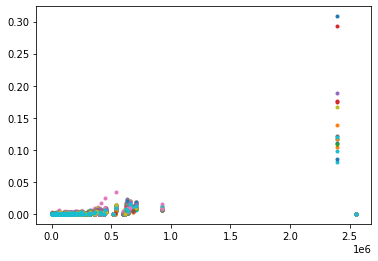

In [9]:
for r2 in all_errors:
    plt.plot(r2, linestyle='', marker='.')
plt.show()

In [10]:
print('r2')
print('train:',r2_score(y_train, train_predicted))
print('test:', r2_score(y_val, val_predicted))

print('mae')
print('train:', mean_absolute_error(y_train, train_predicted))
print('test:', mean_absolute_error(y_val, val_predicted))

r2
train: 0.5647649813638034
test: 0.8829650868630684
mae
train: 8610.159709647482
test: 12780.539514105223


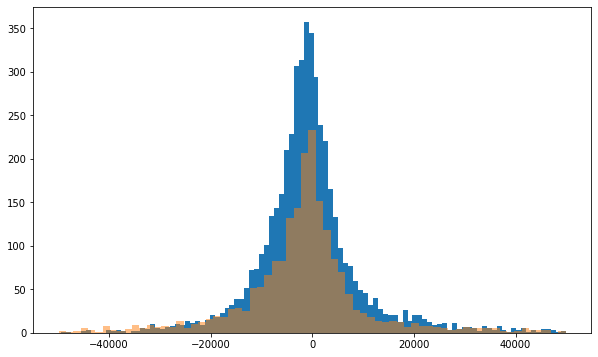

In [11]:
err_train = y_train-train_predicted
err_val = y_val-val_predicted
plt.figure(figsize=(10,6))
plt.hist(err_train[abs(err_train)<50000], bins='auto')
plt.hist(err_val[abs(err_val)<50000], bins='auto', alpha=.5)
plt.show()

## Учим модель и дампим

In [13]:
cat_features, train = prepare_data.prepare_for_radar(df_train,
                                                    train_cols,
                                                    drop_duplicates=True,
                                                    duplicates_subset=None)

pars_cb['cat_features'] = cat_features
clf1 = LGBMRegressor(**pars_lgbm)
clf2 = CatBoostRegressor(**pars_cb)
final_model = ml_scripts.MyStackRegressor([clf1, clf2])
final_radar = ml_scripts.NewsRadar(final_model,
                                    heuristic_features=['url_id', 'ctr'],
                                    estimator_features=train_cols,
                                    round_numeric_to=3)

final_radar.fit(train, train[TARGET_COL], outliers_threshold=OUTLIERS_THRESHOLD)

helpers.dump_pickle(final_radar, os.path.join(ROOT_ABSPATH, MODELS_PATH, f'model_{TARGET_COL}.pickle'))

with open(os.path.join(ROOT_ABSPATH, MODELS_PATH, f'model_{TARGET_COL}_train_cols.json'), 'w', encoding='utf-8') as f:
    json.dump(train_cols, f, ensure_ascii=False, indent=4)

## Интерпретируем составляющие модели
Получаем SHAP-значения для бустинга

/Users/affernus/.pyenv/versions/3.9.4/envs/rbc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


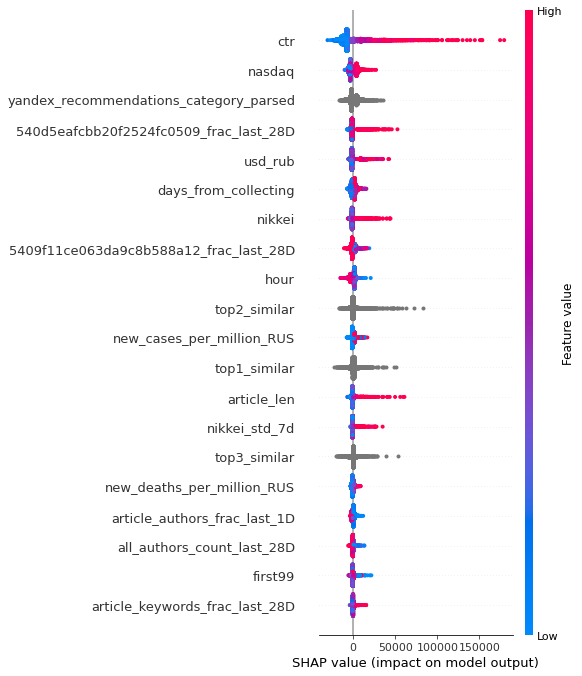

In [14]:
import shap

explainer = shap.TreeExplainer(final_radar.estimator.estimators_list[0])
shap_values_train = explainer.shap_values(train[train_cols])
shap.summary_plot(shap_values_train, train[train_cols], max_display=20)

In [15]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[0]
print(f"Explainer expected value: {expected_value}")

select = range(20)
shap_values_decision = explainer.shap_values(train.iloc[select][train_cols])
features_display = train_cols

Explainer expected value: 26980.80990275436


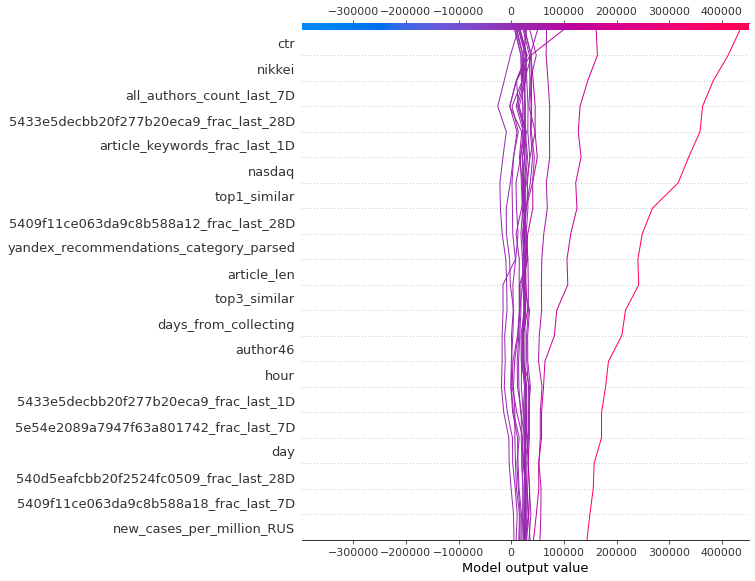

In [16]:
shap.decision_plot(expected_value, shap_values_decision, features_display)

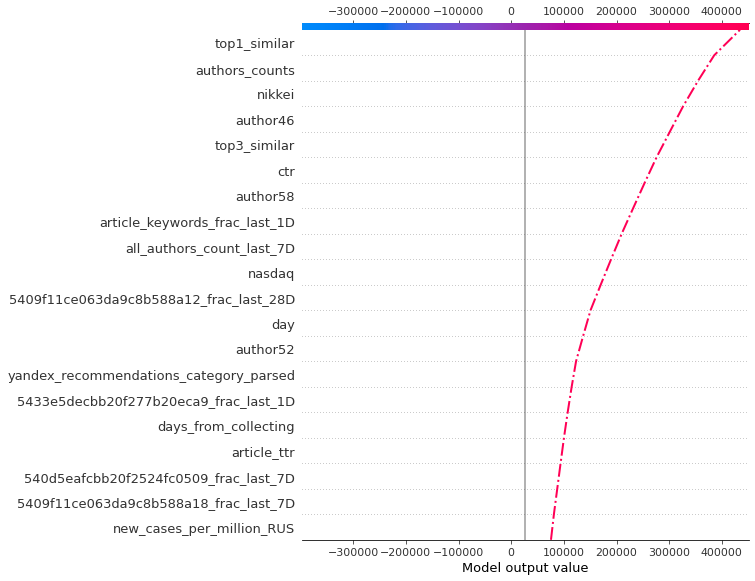

In [17]:
shap.decision_plot(expected_value, shap_values_decision[10], features_display, highlight=0)

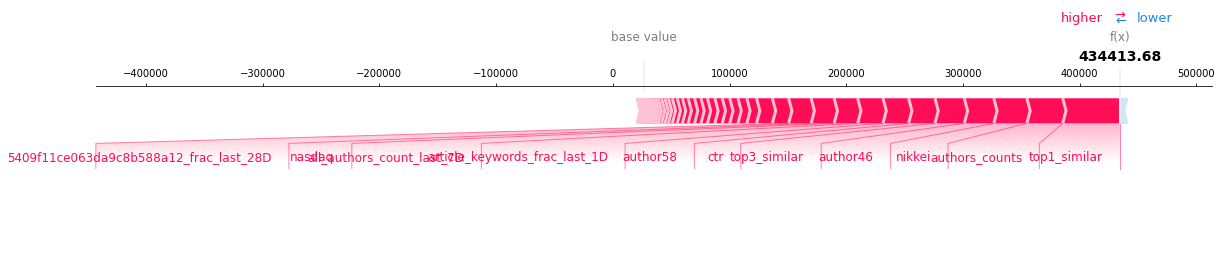

In [18]:
shap.force_plot(expected_value, shap_values_decision[10], features_display, matplotlib=True)